# Regression Modeling & Hypothesis Testing

## 1. Introduction  

In this notebook, we move from descriptive analysis (EDA) and data preparation to **formal hypothesis testing**.  
We focus on the 2024 cross-sectional dataset, where consistent predictors of happiness are available.  
Our main tool will be **multiple linear regression**, which allows us to estimate how different factors are associated with reported happiness levels across countries.  

The aim is not to establish causality, but to identify the strongest statistical associations that help explain global variation in happiness.  



## 2. Research Questions & Hypotheses  

This analysis addresses the following research questions from our study design:

**RQ4**: Which factors (GDP, social support, health, freedom, corruption, generosity) are most strongly associated with happiness across countries in 2024?  
- **H0**: None of the predictors are significantly associated with the happiness ladder score.  
- **H1**: At least one predictor shows a statistically significant association.  

**RQ5**: Which regions and countries stand out in the 2024 dataset relative to the global distribution?  
- *This question will be informed by regression results and regional comparisons, highlighting systematic deviations from global trends.*  



With these hypotheses in place, we now prepare the data for regression analysis.


## 3. Data Preparation

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [14]:
# Load 2024 dataset
df_2024_model = pd.read_csv('../data/processed/world-happiness-2024-model.csv') 

# Quick sanity check
print('df_2024_model shape:', df_2024.shape) # expected 140 rows, 12 columns

df_2024_model shape: (140, 12)


We model the *Ladder score* as the **dependent variable**.  
Predictors are the six key factors from the 2024 dataset:  

- Log GDP per capita  
- Social support  
- Healthy life expectancy  
- Freedom to make life choices  
- Perceptions of corruption  
- Generosity  

As observed in the correlation analysis, *Generosity* and *Perceptions of corruption* show weaker associations with *Ladder score* compared to the other predictors.  
Nevertheless, we start with a **baseline model including all predictors**, and will later test refined specifications.  


## 4. Baseline Model: Linear Regression  

We estimate an OLS regression including all six predictors.  
The model summary provides:  

- Coefficient estimates with p-values (significance levels)  
- R² and adjusted R² (explained variance)  
- Diagnostics such as F-statistic and standard errors  

This serves as a **benchmark** before refining the model.  

In [15]:
# Define formula for OLS regression
formula = "Q('Ladder score') ~ Q('Log GDP per capita') + Q('Social support') + Q('Healthy life expectancy') + Q('Freedom to make life choices') + Q('Perceptions of corruption') + Generosity"

# Fit model
model = smf.ols(formula=formula, data=df_2024_model)
results = model.fit()

# Display regression results
display(results.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Q('Ladder score')   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     100.6
Date:                Wed, 10 Sep 2025   Prob (F-statistic):           5.73e-47
Time:                        16:38:17   Log-Likelihood:                -101.65
No. Observations:                 140   AIC:                             217.3
Df Residuals:                     133   BIC:                             237.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             1.1704      0.207      5.656      0.000       0.761       1.580
Q('Log GDP per capita')               0.4415      0.209      2.115      0.036       0.029       0.854
Q('Social support')                   1.4384      0.212      6.798      0.000       1.020       1.857
Q('Healthy life expectancy')          1.3825      0.494      2.797      0.006       0.405       2.360
Q('Freedom to make life choices')     1.8968      0.323      5.871      0.000       1.258       2.536
Q('Perceptions of corruption')        1.0072      0.409      2.460      0.015       0.198       1.817
Generosity                            0.4621      0.635      0.728      0.468      -0.793       1.717
==============================================================================
Omnibus:                        9.794   Durbin-Watson:                   1.250
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.772
Skew:                          -0.606   Prob(JB):                      0.00755
Kurtosis:                       3.456   Cond. No.                         34.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Key findings
- The model explains 82% of the variance in Ladder Score (adj. R² = 0.811, F = 100.6, p < 0.001).
- Significant positive predictors: Freedom to make life choices, Social support, Healthy life expectancy, Log GDP per capita, and Perceptions of corruption.
- Non-significant predictor: Generosity
- Residual diagnostics indicate some deviation from normality and mild autocorrelation, which should be considered when interpreting coefficients.

Holding other factors constant, higher levels of freedom, social support, life expectancy, GDP, and perceptions of corruption are associated with higher Ladder Scores.

## 5. Model Diagnostics & Robustness Checks  

To validate the regression results, we focus on the most critical checks:  

- **Multicollinearity (VIF):** to confirm predictors are not redundant.  
- **Residual diagnostics:** to check linearity and normality assumptions.  
- **Model comparison:** to evaluate whether alternative specifications (dropping weak predictors or keeping only numeric factors) change the explanatory power.  

In [16]:
# 1. VIF for multicollinearity

X = df_2024_model[['Log GDP per capita', 'Social support', 
                   'Healthy life expectancy', 'Freedom to make life choices',
                   'Perceptions of corruption', 'Generosity']]

X_const = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['Variable'] = X_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i) 
                   for i in range(X_const.shape[1])]

display(vif_data)


,Variable,VIF
0,const,22.768359
1,Log GDP per capita,4.157293
2,Social support,2.625614
3,Healthy life expectancy,3.508979
4,Freedom to make life choices,1.454670
5,Perceptions of corruption,1.409850
6,Generosity,1.146337


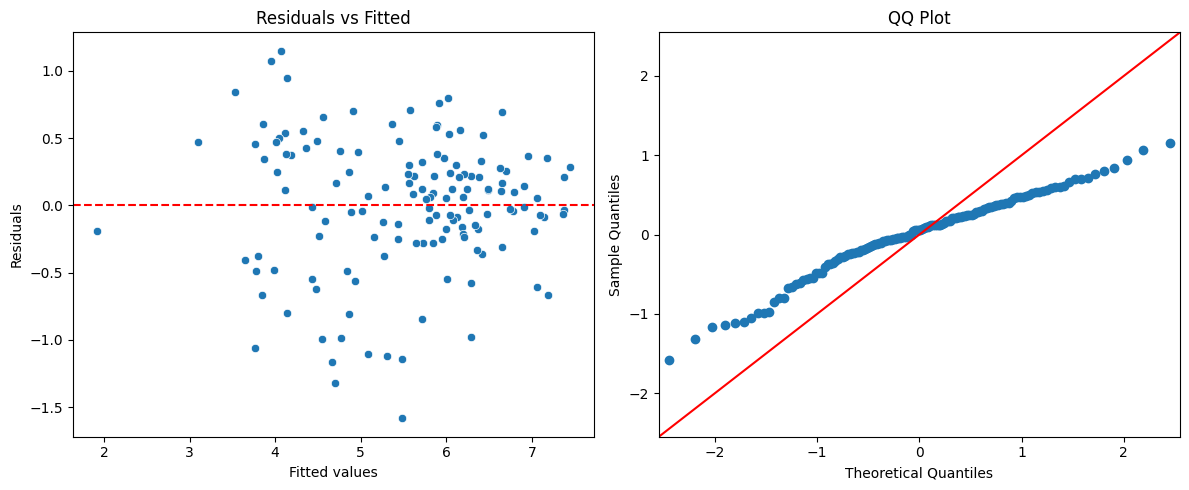

In [17]:
# 2. Residual diagnostics

formula = "Q('Ladder score') ~ Q('Log GDP per capita') + Q('Social support') + Q('Healthy life expectancy') + Q('Freedom to make life choices') + Q('Perceptions of corruption') + Generosity"
model = smf.ols(formula=formula, data=df_2024_model).fit()

residuals = model.resid
fitted = model.fittedvalues

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Residuals vs Fitted
sns.scatterplot(x=fitted, y=residuals, ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Fitted')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')

# QQ plot
sm.qqplot(residuals, line='45', ax=axes[1])
axes[1].set_title('QQ Plot')

plt.tight_layout()
plt.show()

In [18]:
# 3. Model comparison
# ---------------------------
# Reduced model: drop Generosity
model_reduced = smf.ols(
    formula="Q('Ladder score') ~ Q('Log GDP per capita') + Q('Social support') + Q('Healthy life expectancy') + Q('Freedom to make life choices') + Q('Perceptions of corruption')",
    data=df_2024_model
).fit()

# Numeric-only model: GDP + Healthy life expectancy
model_numeric = smf.ols(
    formula="Q('Ladder score') ~ Q('Log GDP per capita') + Q('Healthy life expectancy')",
    data=df_2024_model
).fit()

comparison = pd.DataFrame({
    'Model': ['Full', 'Reduced (no Generosity)', 'Numeric only'],
    'Adj. R²': [model.rsquared_adj, model_reduced.rsquared_adj, model_numeric.rsquared_adj],
    'AIC': [model.aic, model_reduced.aic, model_numeric.aic]
})

display(comparison)

,Model,Adj. R²,AIC
0,Full,0.811299,217.298495
1,Reduced (no Generosity),0.811961,215.855592
2,Numeric only,0.632915,306.607432


### Key Findings

**1. Multicollinearity (VIF):**  
All predictors had VIF values well below the critical threshold of 10, indicating no problematic multicollinearity. GDP (4.16) and healthy life expectancy (3.51) showed moderate correlation with other predictors, but remain within acceptable limits.

**2. Residual diagnostics:**  
The residuals vs. fitted plot showed no clear patterns, suggesting that the linearity assumption is reasonably satisfied. The QQ plot revealed mild deviations from normality in the tails, but overall the residuals approximate a normal distribution closely enough for interpretation. Ordinary Least Squares is robust to such minor deviations, especially with larger samples.

**3. Model comparison:**  
- Full model (all predictors): Adjusted R² = 0.811, AIC = 217.3  
- Reduced model (excluding *Generosity*): Adjusted R² = 0.812, AIC = 215.9  
- Numeric-only model (GDP + Healthy life expectancy): Adjusted R² = 0.633, AIC = 306.6  

The reduced model without *Generosity* performs slightly better, suggesting that *Generosity* does not add meaningful explanatory power. In contrast, excluding all survey-based predictors and relying only on numeric factors leads to a substantial loss of explanatory power.  

**Conclusion:**  
The final preferred model includes GDP, social support, healthy life expectancy, freedom to make life choices, and perceptions of corruption. This specification balances interpretability and predictive performance, while avoiding unnecessary predictors.


## 6. Coefficient Interpretation

The regression coefficients represent the expected change in the *Ladder Score* (happiness) for a one-unit increase in the predictor, holding other variables constant:

- **Freedom to make life choices** (+1.90): The strongest predictor. A one-unit increase in freedom is associated with almost two additional points in the Ladder Score.  
- **Social support** (+1.44) and **Healthy life expectancy** (+1.38): Both have substantial positive effects, highlighting the importance of community and health for well-being.  
- **Log GDP per capita** (+0.44): Economic prosperity has a positive but more moderate effect compared to social and health factors.  
- **Perceptions of corruption** (+1.01): Interestingly, higher values (indicating less corruption) are linked to higher happiness.  
- **Generosity** (+0.46): The effect is small and statistically insignificant (p = 0.47), suggesting it does not reliably predict happiness in this model.

**Key takeaway:** While economic factors matter, social support, freedom, and health appear to be stronger drivers of subjective well-being.


## 7. Hypothesis Testing

In the introduction of this notebook, we formulated a **global hypothesis**:

- **H0 (global null):** None of the predictors are significantly associated with the happiness ladder score.  
- **H1 (global alternative):** At least one predictor is significantly associated.  

Our regression model (Adj. R² ≈ 0.81, F-statistic p < 0.001) allows us to **reject the global null hypothesis**: at least one factor is significantly associated with happiness across countries in 2024.  

We now evaluate each predictor individually:  

- ✅ **Log GDP per capita** → Significant positive effect (p < 0.05)  
- ✅ **Social support** → Strong significant positive effect (p < 0.001)  
- ✅ **Healthy life expectancy** → Significant positive effect (p < 0.01)  
- ✅ **Freedom to make life choices** → Strong significant positive effect (p < 0.001)  
- ✅ **Perceptions of corruption** → Significant positive effect (p < 0.05)  
- ❌ **Generosity** → Not significant (p > 0.05)  

**Conclusion:**  
The regression confirms that **economic, health, and social factors** (GDP, life expectancy, social support, freedom, corruption) are robustly associated with happiness in 2024.  
By contrast, **generosity does not play a systematic role** once other predictors are controlled for.
